In [10]:
from constants import posts_token, all_posts, participants_token, participants_table1
from functions import pull_redcap_report
import pandas as pd

posts = pull_redcap_report(posts_token, all_posts)
participants = pull_redcap_report(participants_token, participants_table1)

# Ensure 'timestamp' in posts is in datetime format
posts['timestamp'] = pd.to_datetime(posts['timestamp'], errors='coerce')
participants['diagnosis_date'] = pd.to_datetime(participants['diagnosis_date'], errors='coerce')

# Group by 'participant_id' to find the first and last post timestamps
participant_activity = posts.groupby('participant_id')['timestamp'].agg(['min', 'max']).reset_index()
participant_activity.rename(columns={'min': 'first_post', 'max': 'last_post'}, inplace=True)


# Create diagnosis group, defaulting missing dx_type to 'Caregiver'
participants['diagnosis_group'] = participants['dx_type'].fillna('Caregiver')

# Calculate total time on Facebook
participant_activity['time_on_facebook'] = participant_activity['last_post'] - participant_activity['first_post']

# Merge in diagnosis and demographics
participant_activity = participant_activity.merge(
    participants[['record_id', 'diagnosis_date', 'dx_type', 'dob', 'diagnosis_group']],
    left_on='participant_id',
    right_on='record_id',
    how='left'
)

# Calculate time before diagnosis
participant_activity['time_before_diagnosis'] = participant_activity['diagnosis_date'] - participant_activity['first_post']

# Drop 'record_id' since we already have 'participant_id'
participant_activity.drop(columns=['record_id'], inplace=True)

# Calculate the number of posts per participant
post_counts = posts.groupby('participant_id').size().reset_index(name='num_posts')

# Merge post counts
participant_activity = participant_activity.merge(post_counts, on='participant_id', how='left')

# Calculate the average number of posts per participant
average_posts_per_participant = participant_activity['num_posts'].mean()

# Convert time_on_facebook to years
participant_activity['time_on_facebook_years'] = participant_activity['time_on_facebook'].dt.total_seconds() / (365.25 * 24 * 3600)

# Calculate the average length of time on Facebook in years
average_facebook_duration_years = participant_activity['time_on_facebook_years'].mean()
sd_facebook_duration_years = participant_activity['time_on_facebook_years'].std()

# Display result
print(f"Average length of time on Facebook: {average_facebook_duration_years:.2f} years (SD = {round(sd_facebook_duration_years,2)})")

# Calculate the average number of posts on Facebook 
average_facebook_posts = participant_activity['num_posts'].mean()
sd_facebook_posts = participant_activity['num_posts'].std()

# Display result
print(f"Average number of posts on Facebook: {average_facebook_posts:.2f} (SD = {round(sd_facebook_posts,2)})")

# Calculate posts per year for each participant
participant_activity['posts_per_year'] = participant_activity['num_posts'] / participant_activity['time_on_facebook_years']

# Handle possible divide-by-zero or NaN values
participant_activity['posts_per_year'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
participant_activity['posts_per_year'] = participant_activity['posts_per_year'].fillna(0)

# Compute average and standard deviation
average_posts_per_year = participant_activity['posts_per_year'].mean()
sd_posts_per_year = participant_activity['posts_per_year'].std()

# Display result
print(f"Average number of posts per year on Facebook: {average_posts_per_year:.2f} (SD = {round(sd_posts_per_year,2)})")

# Summary stats by diagnosis group
summary_by_dx = participant_activity.groupby('diagnosis_group').agg({
    'num_posts': ['mean', 'std'],
    'time_on_facebook_years': ['mean', 'std'],
    'posts_per_year': ['mean', 'std'],
    'participant_id': 'count'  # number of people in each group
}).rename(columns={'participant_id': 'n'})

# Clean up multi-level column names
summary_by_dx.columns = ['_'.join(col).strip() for col in summary_by_dx.columns.values]
summary_by_dx = summary_by_dx.reset_index()

print(summary_by_dx)

Average length of time on Facebook: 13.46 years (SD = 2.84)
Average number of posts on Facebook: 4490.91 (SD = 5636.56)
Average number of posts per year on Facebook: 311.06 (SD = 375.7)
              diagnosis_group  num_posts_mean  num_posts_std  \
0                   Caregiver     5790.083333    5859.190752   
1            Essential Tremor     1354.333333     158.850034   
2         Parkinson's disease     4054.413793    5741.372823   
3  Post traumatic Parkinson's    10969.000000            NaN   

   time_on_facebook_years_mean  time_on_facebook_years_std  \
0                    12.943448                    3.585752   
1                    12.926471                    2.531878   
2                    13.834659                    2.562777   
3                    10.480523                         NaN   

   posts_per_year_mean  posts_per_year_std  n_count  
0           400.989358          377.981699       12  
1           108.213276           29.660610        3  
2           269.4671

In [ ]:
import scipy.stats as stats
from scipy.stats import shapiro

# Subset participant_activity by group
pd_group = participant_activity[participant_activity['diagnosis_group'] == "Parkinson's disease"]
cg_group = participant_activity[participant_activity['diagnosis_group'] == "Caregiver"]

# Drop missing values (if any)
pd_posts_per_year = pd_group['posts_per_year'].dropna()
cg_posts_per_year = cg_group['posts_per_year'].dropna()

# Shapiro-Wilk test for PD group
stat_pd, p_pd = shapiro(pd_posts_per_year)
print(f"PD group: W = {stat_pd:.3f}, p = {p_pd:.4f}")
# Fails normality test

# Shapiro-Wilk test for Caregivers group
stat_cg, p_cg = shapiro(cg_posts_per_year)
print(f"Caregiver group: W = {stat_cg:.3f}, p = {p_cg:.4f}")


# Mann-Whitney U test (non-parametric)
u_stat, p_val_mwu = stats.mannwhitneyu(pd_posts_per_year, cg_posts_per_year, alternative='two-sided')


print("\nMann-Whitney U test:")
print(f"U = {u_stat:.3f}, p = {p_val_mwu:.4f}")


PD group: W = 0.717, p = 0.0000
Caregiver group: W = 0.862, p = 0.0522

Mann-Whitney U test:
U = 119.000, p = 0.1184


In [13]:
# Time on FB among people with movement disorders
# Filter only participants with a movement disorder (i.e., those with a diagnosis date)
patient_activity = participant_activity[pd.notna(participant_activity['diagnosis_date'])].copy()

# Calculate the average length of time on Facebook in years
average_facebook_duration_years = patient_activity['time_on_facebook_years'].mean()
sd_facebook_duration_years = patient_activity['time_on_facebook_years'].std()

# Display result
print(f"Average length of time on Facebook: {average_facebook_duration_years:.2f} years (SD = {round(sd_facebook_duration_years,2)})")

# Calculate the average number of posts on Facebook 
average_facebook_posts = patient_activity['num_posts'].mean()
sd_facebook_posts = patient_activity['num_posts'].std()

# Display result
print(f"Average number of posts on Facebook: {average_facebook_posts:.2f} (SD = {round(sd_facebook_posts,2)})")

# Time before DX
# Convert time_before_diagnosis	 to years
patient_activity['time_before_diagnosis_years'] = patient_activity['time_before_diagnosis'].dt.total_seconds() / (365.25 * 24 * 3600)
# Calculate the average length of time on Facebook in years
average_facebook_duration_years = patient_activity['time_before_diagnosis_years'].mean()
sd_facebook_duration_years = patient_activity['time_before_diagnosis_years'].std()

# Display result
print(f"Average length of time on Facebook before DX: {average_facebook_duration_years:.2f} years (SD = {round(sd_facebook_duration_years,2)})")


Average length of time on Facebook: 13.65 years (SD = 2.56)
Average number of posts on Facebook: 4018.48 (SD = 5569.63)
Average length of time on Facebook before DX: 5.03 years (SD = 5.75)


In [14]:
# PwPD

# Time on FB among people with movement disorders
# Filter only participants with a movement disorder (i.e., those with a diagnosis date)
pd_activity = participant_activity[participant_activity['dx_type'] == "Parkinson's disease"].copy()

# Calculate the average length of time on Facebook in years
average_facebook_duration_years = pd_activity['time_on_facebook_years'].mean()
sd_facebook_duration_years = pd_activity['time_on_facebook_years'].std()

# Display result
print(f"Average length of time on Facebook: {average_facebook_duration_years:.2f} years (SD = {round(sd_facebook_duration_years,2)})")

# Calculate the average number of posts on Facebook 
average_facebook_posts = patient_activity['num_posts'].mean()
sd_facebook_posts = patient_activity['num_posts'].std()

# Display result
print(f"Average number of posts on Facebook: {average_facebook_posts:.2f} (SD = {round(sd_facebook_posts,2)})")

# Time before DX
# Convert time_before_diagnosis	 to years
pd_activity['time_before_diagnosis_years'] = pd_activity['time_before_diagnosis'].dt.total_seconds() / (365.25 * 24 * 3600)
# Calculate the average length of time on Facebook in years
average_facebook_duration_years = pd_activity['time_before_diagnosis_years'].mean()
sd_facebook_duration_years = pd_activity['time_before_diagnosis_years'].std()

# Display result
print(f"Average length of time on Facebook before DX: {average_facebook_duration_years:.2f} years (SD = {round(sd_facebook_duration_years,2)})")

Average length of time on Facebook: 13.83 years (SD = 2.56)
Average number of posts on Facebook: 4018.48 (SD = 5569.63)
Average length of time on Facebook before DX: 5.12 years (SD = 6.12)


In [19]:
# Ensure 'dob' and 'first_post' are in datetime format
pd_activity['dob'] = pd.to_datetime(pd_activity['dob'], errors='coerce')

# Calculate age at newest/oldest post in years
pd_activity['age_at_newest'] = (pd_activity['last_post'] - pd_activity['dob']).dt.total_seconds() / (365.25 * 24 * 3600)
pd_activity['age_at_oldest'] = (pd_activity['first_post'] - pd_activity['dob']).dt.total_seconds() / (365.25 * 24 * 3600)
pd_activity['dx_age'] = (pd_activity['diagnosis_date'] - pd_activity['dob']).dt.total_seconds() / (365.25 * 24 * 3600)

In [ ]:
pd_activity

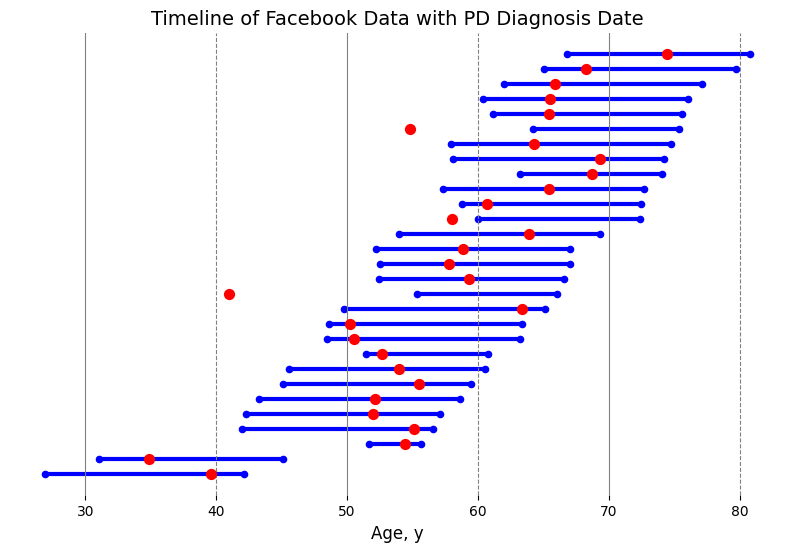

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort DataFrame by 'age_at_newest' in ascending order
pd_activity = pd_activity.sort_values(by='age_at_newest')

# Re-index participant IDs based on sorted order for better visualization
pd_activity['participant_order'] = range(len(pd_activity))

# Create the plot
plt.figure(figsize=(10, 6))

# Draw timeline segments (equivalent to geom_segment)
for index, row in pd_activity.iterrows():
    plt.plot([row['age_at_oldest'], row['age_at_newest']], 
             [row['participant_order'], row['participant_order']], 
             color='blue', 
             linewidth=3)

# Add diagnosis points (equivalent to geom_point)
plt.scatter(pd_activity['dx_age'], pd_activity['participant_order'], 
            color='red', s=50, label="PD Diagnosis", zorder=3)

# Add bulbs at start and finish
plt.scatter(pd_activity['age_at_oldest'], pd_activity['participant_order'], 
            color='blue', s=20, label="Oldest")
plt.scatter(pd_activity['age_at_newest'], pd_activity['participant_order'], 
            color='blue', s=20, label="Newest")

# Labels and title
plt.title("Timeline of Facebook Data with PD Diagnosis Date", fontsize=14)
plt.xlabel("Age, y", fontsize=12)

# Remove y-axis labels and ticks
plt.yticks([])

# Remove top and right borders (sns.despine does this)
sns.despine(left=True, bottom=True)

# Add vertical reference lines at 30, 40, 50, 60, 70, 80
for i, age in enumerate([30, 40, 50, 60, 70, 80]):
    linestyle = '-' if i % 2 == 0 else '--'  # Alternates between solid and dashed
    plt.axvline(x=age, color='gray', linestyle=linestyle, linewidth=0.8)

# Save as SVG
svg_filename = "../figures/PD_Timeline.svg"
plt.savefig(svg_filename, format="svg", bbox_inches="tight")


# Show plot
plt.show()

In [34]:
# Save as SVG
svg_filename = "../figures/PD_Timeline.svg"
plt.savefig(svg_filename, format="svg", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>